# Jupyter and multiple Languages

# IPython and cross language integration

The rest of this is mostly a demo on how cross-language integration works in a Jupyter notebook by using the features of the _Reference IPython Kernel implementation_. These features are completely handled in the kernel so need to be reimplemented on a per-kernel basis. Though they **also** work on pure terminal IPython, nbconvert or any other programmatic use of IPython.

Most of what you will see here are _just_ thin wrappers around already existing libraries. These libraries (and their respective authors) do all the heavy lifting. I just show how seamless a cross language environment can be from the user point of view. The installation of these library might not be easy either and getting all these language to play together can be complex task. It is though becoming easier and easier.

The term _just_ does not imply that the wrappers are simple, or easy to write. It indicate that the wrappers are far from being complete. What is shown here is completely doable using standard Python syntax and bit of manual work. SO what you'll see here is mostly _convenience_. 

### The good old example of Fibonacci

Understanding the multiple languages themselves is not necessary; most of the code here should self explanatory and straightforward. We'll define many function that compute the nth `Fibonacci` number more or less efficiently. We'll define them either using the classic recursive implementation, or sometime using an unrolled optimized version. As a reminder the Fibonacci sequence is defines a the following:

$$ F_n = \begin{cases} 1 &\mbox{if } n \leq 2 \\ 
F_{n-1}+F_{n-2} & \mbox{otherwise }\end{cases}$$

The fact that we calculate the Fibonacci sequence as little importance, except that the value of $F_n$ can grow _really_ fast in $O(e^n)$ if I remember correctly. And the recursive implementation will have a hard time getting beyond (n=100) as the number of call will be greater than $O(e^n)$ as well. Be careful especially if you calculate $F_{F_n}$ or more composition. Remembering that n=5 is stable via $F$ might be useful. 

Here are the first terms of the Fibonacci sequence:

 1. 1
 1. 1
 1. 1+1 = 2
 1. 2+1 = 3
 1. 3+2 = 5
 1. 5+3 = 8
 1. 8+5 = 13
 ...


# Basic Python cross-language integration

Let's define the `fibonacci` function in python:

In [1]:
def fib(n):
    """
    A simple definition of fibonacci manually unrolled
    """
    if n<2:
        return 1
    x,y = 1,1
    for i in range(n-2):
        x,y = y,x+y
    return y

In [2]:
[fib(i) for i in range(1,10)]

[1, 1, 2, 3, 5, 8, 13, 21, 34]

Store the value from 1 to 30 in `Y`, and graph it.

Text(0.5, 1.0, 'The Fibonacci sequence grows fast !')

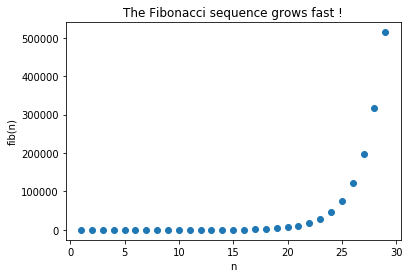

In [3]:
%matplotlib inline
import numpy as np
X = np.arange(1,30)
Y = np.array([fib(x) for x in X])
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(X, Y)
ax.set_xlabel('n')
ax.set_ylabel('fib(n)')
ax.set_title('The Fibonacci sequence grows fast !')

It may not surprise you, but this looks like an exponential, so if we were to look at $log(fib(n))$ × $n$ it would look approximately like a line.:

We can try to do a linear regression using this model. R is a language many people use to do statistics. So, let's use R. 

Let's enable integration between Python and R using the [__`RPy2`__](https://rpy2.readthedocs.io/en/version_2.8.x/) python package developed by Laurent Gautier and the rest of the rpy2 team.

(Side note, you might need to change the environment variable passed to your kernel for this to work.
Here is what I had to do only once.)

In [4]:
#!a2km add-env 'python 3' DYLD_FALLBACK_LIBRARY_PATH=$HOME/anaconda/pkgs/icu-54.1-0/lib:/Users/bussonniermatthias/anaconda/pkgs/zlib-1.2.8-3/lib 

In [5]:
import rpy2.rinterface

%load_ext rpy2.ipython

ModuleNotFoundError: No module named 'rpy2'

The Following will "Send" the X and Y array to R.

In [ ]:
%Rpush Y X

And now let's try to fit a linear model ($ln(Y) = A.X + B$) using R. I'm not a R user myself, so don't take this as idiomatic R.

In [ ]:
%%R
my_summary = summary(lm(log(Y)~X))
val <- my_summary$coefficients

plot(X, log(Y))
abline(my_summary)

In [ ]:
%%R
my_summary

Good, we have now the some statistics on the fit, which also looks good. __And__ we were able to not only send variable to R, but to plot directly from R !

We are happy as $F_n = \left[\frac{\phi^n}{\sqrt 5}\right]$, where `[]` is closest integer and $\phi = \frac{1+\sqrt 5}{2}$

We can also look at the variables more carefully

In [ ]:
%%R
val

Or even the following that _looks_ more like python

In [ ]:
%R val

We can even get the variable back from R as Python objects:

In [ ]:
coefs

In [ ]:
coefs = %Rget val
y0,k = coefs[0:2]
y0,k

That's all from the R part. I hope this shows you some of the power of IPython, both in notebook and command line. 

## Cython

IPython used to ship with the Cython magic that is now part of [Cython](http://cython.org/) itself.
Cython is a superset of Python that compiles to C and importable from Python. You should be a ble to take your python code as is, type annotate it, and get c-like speed.
The same principle applies:

In [6]:
import cython

In [7]:
%load_ext cython

In [8]:
%%cython

def cyfib(int n): # note the `int` here
    """
    A simple definition of fibonacci manually unrolled
    """
    cdef int x,y # and the `cdef int x,y` here
    if n < 2:
        return 1
    x,y = 1,1
    for i in range(n-2):
        x,y = y,x+y
    return y

DistutilsPlatformError: Unable to find vcvarsall.bat

In [9]:
[cyfib(x) for x in range(1,10)]

NameError: name 'cyfib' is not defined

###  benchmark

In [10]:
%timeit -n100 -r3 fib(5)

2.53 µs ± 1.72 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


In [11]:
%timeit -n100 -r3 cyfib(5)

NameError: name 'cyfib' is not defined

The benchmark result can be astonishing, but keep in mind that the Python and Cython version use manually unrolled loop. Main point being that we reached our goal and used Fortran, Cython, C (and Rust) in the middle of our Python program.

Try adding a loop around the `%timeit` magic and see if yu can get a graph of runtime vs fibonaci-number for both functions.